In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, scale
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
import matplotlib.pyplot as plt

In [2]:
# Load data
df_US = pd.read_csv('./USvideos.csv')
df_CA = pd.read_csv('./CAvideos.csv')
print(df_US.shape)
print(df_CA.shape)
df_US.head(3)

(40949, 16)
(40881, 16)


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...


In [3]:
#get rid some features
df_train = df_US.copy()[['category_id','views','likes','dislikes','comment_count']]
df_test = df_CA.copy()[['category_id','views','likes','dislikes','comment_count']]

In [4]:
features_train = pd.get_dummies(df_train)
features_test = pd.get_dummies(df_test)

In [5]:
features_train = df_train.drop('likes',axis=1)
features_test = df_test.drop('likes',axis=1)
target_train = df_train.likes
target_test = df_test.likes

In [6]:
# creats extra features to increase the accuracy of prediction
poly = PolynomialFeatures(2,interaction_only=True,include_bias = False)
features_e_train = poly.fit_transform(features_train)
features_e_test = poly.fit_transform(features_test)
cols_train = poly.get_feature_names(features_train.columns)
cols_test = poly.get_feature_names(features_test.columns)
features_e_train = pd.DataFrame(features_e_train,columns=cols_train)
features_e_test = pd.DataFrame(features_e_test,columns=cols_test)
print('before:   features_train shape',features_train.shape)
print('after： features_e_train shape',features_e_train.shape)
print('before:   features_test shape',features_test.shape)
print('after： features_e_test shape',features_e_test.shape)
features_e_train.head(3)

before:   features_train shape (40949, 4)
after： features_e_train shape (40949, 10)
before:   features_test shape (40881, 4)
after： features_e_test shape (40881, 10)


,category_id,views,dislikes,comment_count,category_id views,category_id dislikes,category_id comment_count,views dislikes,views comment_count,dislikes comment_count
0,22.0,748374.0,2966.0,15954.0,16464228.0,65252.0,350988.0,2.219677e+09,1.193956e+10,47319564.0
1,24.0,2418783.0,6146.0,12703.0,58050792.0,147504.0,304872.0,1.486584e+10,3.072580e+10,78072638.0
2,23.0,3191434.0,5339.0,8181.0,73402982.0,122797.0,188163.0,1.703907e+10,2.610912e+10,43678359.0


In [7]:
# standardize features
features_e_train = (features_e_train - features_e_train.mean())/features_e_train.std()
features_e_test = (features_e_test - features_e_test.mean())/features_e_test.std()
features_e_train.head(3)

,category_id,views,dislikes,comment_count,category_id views,category_id dislikes,category_id comment_count,views dislikes,views comment_count,dislikes comment_count
0,0.267902,-0.218067,-0.025677,0.200564,-0.205372,-0.002257,0.303405,-0.040953,-0.056854,-0.027302
1,0.532161,0.007844,0.083866,0.113709,0.196124,0.121259,0.234784,-0.036153,-0.050885,-0.026175
2,0.400032,0.112339,0.056067,-0.007101,0.344341,0.084157,0.061121,-0.035328,-0.052352,-0.027436


In [8]:
# create bias column of ones
features_e_train['bias'] =1
features_e_test['bias'] = 1
features_e_train.head(3)

,category_id,views,dislikes,comment_count,category_id views,category_id dislikes,category_id comment_count,views dislikes,views comment_count,dislikes comment_count,bias
0,0.267902,-0.218067,-0.025677,0.200564,-0.205372,-0.002257,0.303405,-0.040953,-0.056854,-0.027302,1
1,0.532161,0.007844,0.083866,0.113709,0.196124,0.121259,0.234784,-0.036153,-0.050885,-0.026175,1
2,0.400032,0.112339,0.056067,-0.007101,0.344341,0.084157,0.061121,-0.035328,-0.052352,-0.027436,1


In [9]:
features_e_train['comments_disabled']=df_US['comments_disabled']
features_e_train['ratings_disabled']=df_US['ratings_disabled']
features_e_train['video_error_or_removed']=df_US['video_error_or_removed']

features_e_test['comments_disabled']=df_CA['comments_disabled']
features_e_test['ratings_disabled']=df_CA['ratings_disabled']
features_e_test['video_error_or_removed']=df_CA['video_error_or_removed']

# Linear Regression

In [10]:
lr = LinearRegression()

In [11]:
# coefficients
lr.fit(features_e_train,target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [12]:
# cross-validation
results = cross_validate(lr, features_e_train, target_train, return_train_score=True,cv=5)
R2_train = results['train_score'].mean()
R2_test = results['test_score'].mean()
print('train R2',R2_train.round(3))
print('test R2',R2_test.round(3))

train R2 0.907
test R2 0.688


## Ridge Regression

In [13]:
grid = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
ridge = Ridge()
ridgeCV = GridSearchCV(ridge, param_grid=grid, return_train_score=True,cv=5)
ridgeCV.fit(features_e_train, target_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000, 100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [14]:
print('best alpha',ridgeCV.best_params_)
print('test R2', ridgeCV.best_score_.round(3))

best alpha {'alpha': 1000}
test R2 0.836


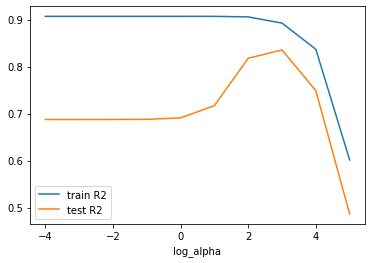

In [15]:
results = pd.DataFrame()
results['log_alpha'] = np.log10(grid['alpha'])
results['train R2'] = ridgeCV.cv_results_['mean_train_score']
results['test R2'] = ridgeCV.cv_results_['mean_test_score']
ax1 = results.plot.line(x='log_alpha',y='train R2')
results.plot.line(x='log_alpha',y='test R2', ax = ax1)

In [16]:
ridge_best = ridgeCV.best_estimator_
coef = ridge_best.coef_
coef = pd.Series(coef, index = features_e_train.columns)
coef.sort_values(ascending = False)

comment_count                175595.791234
views                        110102.611284
views dislikes                19737.898394
category_id views              5485.648437
dislikes                       1356.352811
bias                              0.000000
video_error_or_removed          -71.247408
category_id                   -6951.017870
comments_disabled             -7648.229382
ratings_disabled             -10368.867401
views comment_count          -19189.719577
category_id comment_count    -26197.722633
category_id dislikes         -26508.190402
dislikes comment_count       -38429.767152
dtype: float64

## Lasso Regression

In [17]:
grid = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
lasso = Lasso()
lassoCV = GridSearchCV(lasso, param_grid=grid, return_train_score=True,cv=5)
lassoCV.fit(features_e_train, target_train)

C:\Users\linj2\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80826637036487.11, tolerance: 187444762945.26486
  positive)
C:\Users\linj2\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85953817864669.55, tolerance: 199932255088.2087
  positive)
C:\Users\linj2\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80415524184381.38, tolerance: 199123061122.90707
  positive)
C:\Users\linj2\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000, 100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [18]:
print('best alpha',lassoCV.best_params_)
print('test R2', lassoCV.best_score_.round(3))

best alpha {'alpha': 1000}
test R2 0.83


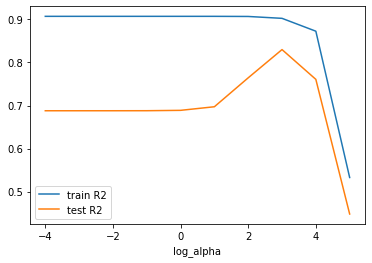

In [19]:
results = pd.DataFrame()
results['log_alpha'] = np.log10(grid['alpha'])
results['train R2'] = lassoCV.cv_results_['mean_train_score']
results['test R2'] = lassoCV.cv_results_['mean_test_score']
ax1 = results.plot.line(x='log_alpha',y='train R2')
results.plot.line(x='log_alpha',y='test R2', ax = ax1)

In [20]:
lasso_best = lassoCV.best_estimator_
coef = lasso_best.coef_
coef = pd.Series(coef, index = features_e_train.columns)
coef.sort_values(ascending = False).round(3)

comment_count                226084.206
views                        116405.550
views dislikes                22882.239
video_error_or_removed            0.000
ratings_disabled                 -0.000
comments_disabled                -0.000
bias                              0.000
category_id dislikes             -0.000
category_id views                 0.000
category_id                   -1763.786
dislikes                     -12312.207
views comment_count          -37899.414
dislikes comment_count       -42602.505
category_id comment_count    -68925.159
dtype: float64

## Ridge Regression is better fit than Lasso Regression

In [21]:
predict = ridgeCV.predict(features_e_test)

In [22]:
df_CA['predict_likes'] = predict.round(0)

In [23]:
df_CA.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description', 'predict_likes'],
      dtype='object')

In [24]:
df_compare = df_CA.copy()[['video_id','title', 'channel_title','publish_time','thumbnail_link', 'likes','predict_likes','dislikes', 'comment_count','category_id']]
df_compare.head(3)

,video_id,title,channel_title,publish_time,thumbnail_link,likes,predict_likes,dislikes,comment_count,category_id
0,n1WpP7iowLc,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,2017-11-10T17:00:03.000Z,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,787425,1470006.0,43420,125882,10
1,0dBIkQ4Mz1M,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,2017-11-13T17:00:00.000Z,https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg,127794,120971.0,1688,13030,23
2,5qpjK5DgCt4,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,2017-11-12T19:05:24.000Z,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,146035,158869.0,5339,8181,23


In [25]:
df_compare['difference'] = (df_compare.likes - df_compare.predict_likes).abs()

## Top 10 prediction with lowest difference

In [26]:
df_compare.sort_values(by=['difference'],ascending=True).head(10)

,video_id,title,channel_title,publish_time,thumbnail_link,likes,predict_likes,dislikes,comment_count,category_id,difference
23708,GsycvDyFZ_c,早晨新聞 2018 03 12【立法會補選】投票率僅43% 范國威區諾軒勝出姚松炎落敗/姚松...,香港新聞報道 【歡迎訂閱】 HK News,2018-03-12T00:10:12.000Z,https://i.ytimg.com/vi/GsycvDyFZ_c/default.jpg,11,9.0,7,56,25,2.0
24700,kuSZEZ0fCY0,Yoga Wash - Detox Flow | Yoga With Adriene,Yoga With Adriene,2018-03-18T08:00:01.000Z,https://i.ytimg.com/vi/kuSZEZ0fCY0/default.jpg,1857,1854.0,19,243,26,3.0
24682,olkgPzlh5A8,"Comedian Norm Macdonald talks Trump, PM Trudeau",CTV News,2018-03-18T22:46:43.000Z,https://i.ytimg.com/vi/olkgPzlh5A8/default.jpg,102,99.0,27,93,25,3.0
33482,xdGI_JTV9_8,Joe Santagato & Danny Lopriore on Church,The Basement Yard,2018-05-07T18:18:54.000Z,https://i.ytimg.com/vi/xdGI_JTV9_8/default.jpg,2158,2162.0,8,127,24,4.0
4971,YkG4Yvwucxo,New Christmas Dresses Try on Haul & An Emotion...,Amelia Liana,2017-12-07T15:57:55.000Z,https://i.ytimg.com/vi/YkG4Yvwucxo/default.jpg,1253,1257.0,62,263,26,4.0
40810,RtI8iieSHqU,[SHINee's BACK] Ep.3 산소같은 너(Love Like Oxygen) ...,M2,2018-06-13T12:00:02.000Z,https://i.ytimg.com/vi/RtI8iieSHqU/default.jpg,25125,25120.0,61,2165,24,5.0
9575,gvJeFFybxxU,Ezra Levant's Year in Review: How The Rebel Me...,Rebel Media,2017-12-29T14:30:02.000Z,https://i.ytimg.com/vi/gvJeFFybxxU/default.jpg,590,596.0,21,156,25,6.0
16742,9PT3ucAFmhg,The Last Word with Lawrence O'Donnell February...,NEWS UK,2018-02-07T04:06:52.000Z,https://i.ytimg.com/vi/9PT3ucAFmhg/default.jpg,183,189.0,6,96,25,6.0
18940,2zHH6__GUXk,When Your Favorite Character Dies in an Anime,RDCworld1,2018-02-17T00:02:22.000Z,https://i.ytimg.com/vi/2zHH6__GUXk/default.jpg,38574,38567.0,155,4083,24,7.0
3183,w2A8q3XIhu0,Why Hold Music Sounds Worse Now,Tom Scott,2017-11-27T16:00:04.000Z,https://i.ytimg.com/vi/w2A8q3XIhu0/default.jpg,21186,21178.0,249,1275,27,8.0


## Top 10 prediction with highest difference

In [27]:
df_compare.sort_values(by=['difference'],ascending=False).head(10)

,video_id,title,channel_title,publish_time,thumbnail_link,likes,predict_likes,dislikes,comment_count,category_id,difference
36453,7C2z4GqqS5E,BTS (방탄소년단) 'FAKE LOVE' Official MV,ibighit,2018-05-18T09:00:02.000Z,https://i.ytimg.com/vi/7C2z4GqqS5E/default.jpg,5053338,9314245.0,165854,1114800,10,4260907.0
36153,7C2z4GqqS5E,BTS (방탄소년단) 'FAKE LOVE' Official MV,ibighit,2018-05-18T09:00:02.000Z,https://i.ytimg.com/vi/7C2z4GqqS5E/default.jpg,4924056,9020585.0,156026,1084435,10,4096529.0
35900,7C2z4GqqS5E,BTS (방탄소년단) 'FAKE LOVE' Official MV,ibighit,2018-05-18T09:00:02.000Z,https://i.ytimg.com/vi/7C2z4GqqS5E/default.jpg,4750254,8635760.0,141966,1040912,10,3885506.0
35685,7C2z4GqqS5E,BTS (방탄소년단) 'FAKE LOVE' Official MV,ibighit,2018-05-18T09:00:02.000Z,https://i.ytimg.com/vi/7C2z4GqqS5E/default.jpg,4470888,7803400.0,119046,905912,10,3332512.0
34599,32sYGCOYJUM,CHẠY NGAY ĐI | RUN NOW | SƠN TÙNG M-TP | Offic...,Sơn Tùng M-TP Official,2018-05-11T17:00:47.000Z,https://i.ytimg.com/vi/32sYGCOYJUM/default.jpg,827026,3952908.0,135931,445251,10,3125882.0
34369,32sYGCOYJUM,CHẠY NGAY ĐI | RUN NOW | SƠN TÙNG M-TP | Offic...,Sơn Tùng M-TP Official,2018-05-11T17:00:47.000Z,https://i.ytimg.com/vi/32sYGCOYJUM/default.jpg,753626,3620059.0,118983,401470,10,2866433.0
4699,6ZfuNTqbHE8,Marvel Studios' Avengers: Infinity War Officia...,Marvel Entertainment,2017-11-29T13:26:24.000Z,https://i.ytimg.com/vi/6ZfuNTqbHE8/default.jpg,2606665,4893180.0,53011,347982,24,2286515.0
4451,6ZfuNTqbHE8,Marvel Studios' Avengers: Infinity War Officia...,Marvel Entertainment,2017-11-29T13:26:24.000Z,https://i.ytimg.com/vi/6ZfuNTqbHE8/default.jpg,2584675,4785954.0,52176,341571,24,2201279.0
29241,FhllRWReNEE,Melting Every Lipstick From Sephora Together,Safiya Nygaard,2018-04-14T19:55:26.000Z,https://i.ytimg.com/vi/FhllRWReNEE/default.jpg,335949,2503581.0,6707,349112,22,2167632.0
34361,VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,2018-05-06T04:00:07.000Z,https://i.ytimg.com/vi/VYOjWnS4cMY/default.jpg,3037318,5197216.0,161813,319502,10,2159898.0


### The reasons behind the inaccuracy might be that:
1. We have poor features, the features we used did not have a high enough correlation to the values we are trying to predict, which is the number of likes in our experiement.
2. We need more training data. The more trainning will definitely help us to predict the target more accurately.